# Multilayer Perception

Our goal here is to implement a two-layer neural network for binary classification, train it using gradient descent and use it to classify the Iris dataset.
Our model is
$$
\hat{y} = \sigma \left ( W \sigma \left ( V x \right ) \right)
$$
where we have $M$ hidden units and $D$ input features -- that is $w \in \mathbb{R}^{M}$, and $V \in \mathbb{R}^{M \times D}$. For simplicity here we do not include a bias parameter for each layer. Key to our implementation is the gradient calculation. We follow the notation used in the slides here.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
from sklearn import datasets
import scipy

In [2]:
logistic = lambda z: 1./ (1 + np.exp(-z))

class MLP_Binary:
    
    def __init__(self, M = 64):
        self.M = M
            
    def fit(self, x, y, optimizer):
        N,D = x.shape
        def gradient(x, y, params):
            v, w = params
            z = logistic(np.dot(x, v)) #N x M
            yh = logistic(np.dot(z, w))#N
            dy = yh - y #N
            dw = np.dot(z.T, dy)/N #M
            dz = np.outer(dy, w) #N x M
            dv = np.dot(x.T, dz * z * (1 - z))/N #D x M
            dparams = np.array([dv, dw])
            return dparams
        
        w = np.random.randn(self.M) * .01
        v = np.random.randn(D,self.M) * .01
        params0 = np.array([v,w])
        self.params = optimizer.run(gradient, x, y, params0)
        
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(np.dot(x, v)) #N x M
        yh = logistic(np.dot(z, w))#N
        return yh

In [3]:
expnormalize = lambda z: z - np.reshape(np.max(z, axis=-1),(-1,1))
softmax = lambda z: np.exp(expnormalize(z))/np.reshape(np.sum(np.exp(expnormalize(z)), axis=-1),(-1,1))
CELoss = lambda y, yh : -np.sum(np.log(yh)*y)

class MLP_Multiclass:
    
    def __init__(self, M=64):
        self.M = M
        
    def fit(self, x, y, optimizer):
        N,D = x.shape
        _,C = y.shape
        
        def gradient(x, y, params):
            v, w = params
            z = logistic(x@v)
            yh = softmax(z@w)
            dy = yh - y
            dw = ((z.T)@dy)/N
            dz = dy@(w.T)
            dq = (dz * z * (1-z))/N
            dv = ((x.T)@dq)/N
            dparams = np.array([dv, dw])
            return dparams
        
        w = np.random.randn(self.M,C)
        v = np.random.randn(D,self.M)
        params0 = np.array([v,w])
        self.params = optimizer.run(gradient, x, y, params0)
        return self
    
    def predict(self, x):
        v, w = self.params
        z = logistic(x@v)
        yh = softmax(z@w)
        return yh

In [4]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.epsilon = epsilon
        
    def run(self, gradient_fn, x, y, params):
        norms = np.array([np.inf])
        t = 1
        while np.any(norms > self.epsilon) and t < self.max_iters:
            grad = gradient_fn(x, y, params)
            for p in range(len(params)):
                params[p] -= self.learning_rate * grad[p]
            t += 1
            norms = np.array([np.linalg.norm(g) for g in grad])
        return params

# Iris dataset, binary

Text(0.5, 1.0, 'decision boundary of the MLP')

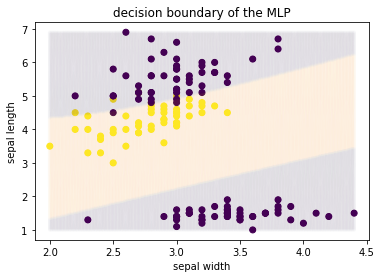

In [5]:
dataset = datasets.load_iris()
x_train, y_train = dataset['data'][:,1:3], dataset['target']
y_train = y_train==1
model = MLP_Binary(M=32)
optimizer = GradientDescent(learning_rate=0.1, max_iters=20000)
y_hat = model.fit(x_train,y_train, optimizer).predict(x_train)
x0_value = np.linspace(np.min(x_train[:,0]), np.max(x_train[:,0]), 200)
x1_value = np.linspace(np.min(x_train[:,1]), np.max(x_train[:,1]), 200)
x0, x1 = np.meshgrid(x0_value, x1_value)
x_all = np.vstack((x0.ravel(), x1.ravel())).T
yh_all = model.predict(x_all) > 0.5
plt.scatter(x_train[:,0], x_train[:,1], c=y_train, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')

# Iris dataset, multiclass

In [6]:
def one_hot_encode(y):
    b = np.zeros((y.size, y.max()+1))
    b[np.arange(y.size),y] = 1
    return b

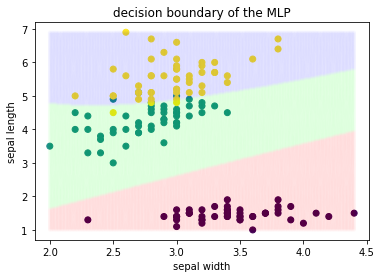

In [7]:
dataset = datasets.load_iris()
x, y = dataset['data'][:,[1,2]], dataset['target']
y_ohe = one_hot_encode(y)
model = MLP_Multiclass(M=32)
optimizer = GradientDescent(learning_rate=.1, max_iters=200000)
yh = model.fit(x, y_ohe, optimizer).predict(x) 
x0v = np.linspace(np.min(x[:,0]), np.max(x[:,0]), 200)
x1v = np.linspace(np.min(x[:,1]), np.max(x[:,1]), 200)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T
yh_all = model.predict(x_all) > 0.5
plt.scatter(x[:,0], x[:,1], c=y, marker='o', alpha=1)
plt.scatter(x_all[:,0], x_all[:,1], c=yh_all, marker='.', alpha=.01)
plt.ylabel('sepal length')
plt.xlabel('sepal width')
plt.title('decision boundary of the MLP')
plt.show()